In [3]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data=load_svmlight_file('a9a.txt')
X_train=data[0].todense()
y_train=data[1]

In [5]:
data=load_svmlight_file('a9a.t')
X_validation=data[0].todense()
y_validation=data[1]

In [6]:
#x为列向量
X_train=X_train.T
#x0=1
x_0=np.ones(X_train.shape[1])
X_train=np.row_stack((X_train,x_0))
#y为行向量
y_train=np.mat(y_train)

#x为列向量
X_validation=X_validation.T
a=np.zeros(X_validation.shape[1])
#x0=1
x_0=np.ones(X_validation.shape[1])
X_validation=np.row_stack((X_validation,a))
X_validation=np.row_stack((X_validation,x_0))
#y为行向量
y_validation=np.mat(y_validation)

In [7]:
for i in range(y_train.shape[1]):
    if y_train[0,i]==-1.0:
        y_train[0,i]=0
for i in range(y_validation.shape[1]):
    if y_validation[0,i]==-1.0:
        y_validation[0,i]=0

In [8]:
def Loss(w,x,y):
    loss=0
    tmp=w.T*x
    loss+=-(tmp*y.T)[0,0]
    for i in range(tmp.shape[1]):
        loss+=np.log(1+np.exp(tmp[0,i]))
    return loss/float(y.shape[1])

In [9]:
def SGD(w,x,y,learning_rate):
    gradient=np.mat(np.zeros(w.shape))
    for i in [np.random.randint(0,x.shape[1]) for i in range(20)]:
        gradient+=-x[:,i]*(y[0,i]-(np.exp(w.T*x[:,i])/(1+np.exp(w.T*x[:,i]))))
    w=w-learning_rate*gradient
    return w

In [10]:
def SGD_NAG(w,m,x,y,learning_rate):
    momentum=m
    gradient=np.mat(np.zeros(w.shape))
    
    for i in [np.random.randint(0,x.shape[1]) for i in range(20)]:
        gradient+=-x[:,i]*(y[0,i]-(np.exp((w-momentum).T*x[:,i])/(1+np.exp((w-momentum).T*x[:,i]))))
    momentum=0.9*momentum+learning_rate*gradient
    w=w-momentum
    return w,momentum

In [11]:
def SGD_RMSProp(w,g,x,y,learning_rate):
    gradient=np.mat(np.zeros(w.shape))
    for i in [np.random.randint(0,x.shape[1]) for i in range(20)]:
        gradient+=-x[:,i]*(y[0,i]-(np.exp(w.T*x[:,i])/(1+np.exp(w.T*x[:,i]))))
    g=0.9*g+0.1*(gradient.T*gradient)[0,0]
    w=w-(learning_rate/(np.sqrt(g+1e-8)))*gradient
    return w,g
    

In [19]:
def SGD_AdaDelta(w,g,delta,x,y):
    gradient=np.mat(np.zeros(w.shape))
    for i in [np.random.randint(0,x.shape[1]) for i in range(20)]:
        gradient=-x[:,i]*(y[0,i]-(np.exp(w.T*x[:,i])/(1+np.exp(w.T*x[:,i]))))
    g=0.95*g+0.05*(gradient.T*gradient)[0,0]
    
    step_length=(np.sqrt(delta+1e-8)/np.sqrt(g+1e-8))*gradient
    w=w-step_length
    delta=0.95*delta+0.05*(step_length.T*step_length)[0,0]
    return w,g,delta

In [20]:
def SGD_Adam(w,m,g,x,y,learning_rate,iter_num):
    gradient=np.mat(np.zeros(w.shape))
    for i in [np.random.randint(0,x.shape[1]) for i in range(20)]:
        gradient=-x[:,i]*(y[0,i]-(np.exp(w.T*x[:,i])/(1+np.exp(w.T*x[:,i]))))
    m=0.9*m+0.1*gradient
    g=0.999*g+0.001*gradient.T*gradient
    alpha=learning_rate*np.sqrt(1-0.999**iter_num)/(1-0.9**iter_num)
    w=w-alpha*m/np.sqrt(g+1e-8)
    return w,m,g

In [21]:
#-------------------没有优化------------
#初始化参数
W=np.mat(np.zeros(X_train.shape[0])).T
iter_num=2000
learning_rate=0.002

loss_validation=[]
loss_validation.append(Loss(W,X_validation,y_validation))
for i in range(iter_num):
    W=SGD(W,X_train,y_train,learning_rate)
    loss_validation.append(Loss(W,X_validation,y_validation))

In [22]:
#-----------------NAG优化
#初始化参数
W=np.mat(np.zeros(X_train.shape[0])).T
momentum=np.mat(np.zeros(X_train.shape[0])).T
iter_num=2000
learning_rate=0.002

loss_NAG_validation=[]
loss_NAG_validation.append(Loss(W,X_validation,y_validation))
for i in range(iter_num):
    W,momentum=SGD_NAG(W,momentum,X_train,y_train,learning_rate)

    loss_NAG_validation.append(Loss(W,X_validation,y_validation))


In [23]:
#------------RMSProp优化
#初始化参数
W=np.mat(np.zeros(X_train.shape[0])).T
g=0
iter_num=2000
learning_rate=0.1

loss_RMSProp_validation=[]
loss_RMSProp_validation.append(Loss(W,X_validation,y_validation))
for i in range(iter_num):
    W,g=SGD_RMSProp(W,g,X_train,y_train,learning_rate)
    loss_RMSProp_validation.append(Loss(W,X_validation,y_validation))


In [24]:
#--------------AdaDelta
#初始化参数
W=np.mat(np.zeros(X_train.shape[0])).T
g=0.0
delta=0.003
iter_num=2000
loss_AdaDelta_validation=[]
loss_AdaDelta_validation.append(Loss(W,X_validation,y_validation))
for i in range(iter_num):
    W,g,delta=SGD_AdaDelta(W,g,delta,X_train,y_train)
    loss_AdaDelta_validation.append(Loss(W,X_validation,y_validation))


In [25]:
#--------------------Adam优化
#初始化参数
W=np.mat(np.zeros(X_train.shape[0])).T
g=0.0
learning_rate=0.1
momentum=np.mat(np.zeros(W.shape))
iter_num=2000

loss_Adam_validation=[]
loss_Adam_validation.append(Loss(W,X_validation,y_validation))

for i in range(iter_num):
    W,m,g=SGD_Adam(W,momentum,g,X_train,y_train,learning_rate,i+1)

    loss_Adam_validation.append(Loss(W,X_validation,y_validation))

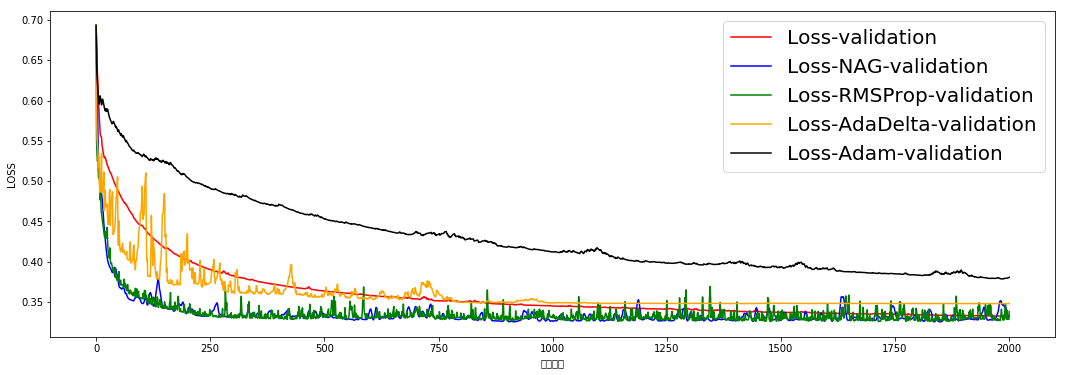

In [26]:
plt.figure(figsize=(18,6))
plt.plot(loss_validation,color='red',label='Loss-validation')
plt.plot(loss_NAG_validation,color='blue',label='Loss-NAG-validation')
plt.plot(loss_RMSProp_validation,color='green',label='Loss-RMSProp-validation')
plt.plot(loss_AdaDelta_validation,color='orange',label='Loss-AdaDelta-validation')
plt.plot(loss_Adam_validation,color='black',label='Loss-Adam-validation')
plt.xlabel('迭代次数')
plt.ylabel('LOSS')
plt.legend(fontsize=20)
plt.show()